In [ ]:
import numpy as np
import numpy.random as npr

from tqdm import tqdm

%matplotlib inline
import matplotlib 
matplotlib.use('pdf')
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Histogram eigenvalues of each X'X
def histeig(eigs, ax, xgrid=None, dgrid=None, bins=100, xlim=None, ylim=None, title=None):
    if xlim is not None:
        eigs = eigs[np.nonzero(eigs <= xlim[1])[0]]
        h = ax.hist(eigs, bins=np.linspace(xlim[0], xlim[1], num=bins))
    else:
        h = ax.hist(eigs, bins=bins)
    if xgrid is not None:
        space = h[1][1] - h[1][0]
        ax.plot(xgrid, dgrid * len(eigs) * space, 'r', label='Prediction at initial', linewidth=2)
        ax.legend()
    ax.set_title(title, fontsize=12)
    ax.set_xlim(xlim)
    if ylim is None:
        ax.set_ylim([0, max(h[0]) * 1.5])
    else:
        ax.set_ylim(ylim)
    return ax

**Activation Functions**

In [ ]:
def lin(X):
  return X
# relu
# b0 = 1/4
# b1 = 1/4
def relu(X,normalize=True):
    X[X<0] = 0
    if normalize:
        return np.sqrt(2*np.pi/(np.pi-1))*(X-1/np.sqrt(2*np.pi))
    else:
        return X

def relu_grad(X,normalize=True):
    X[X<0] = 0
    X[X>0] = 1
    if normalize:
        X[X>0] = np.sqrt(2*np.pi/(np.pi-1))
    return X

# softplus
# b0 = 1/4
# b1 = 0.043379
SP = torch.nn.Softplus()
def softplus(X,normalize=True):
    if normalize:
        c0 = 0.806059
        c1 = 0.271514
        return (SP(X)-c0) / (c1)**0.5
    else:
        return SP(X)

def softplus_grad(X,normalize=True):
    if normalize:
        c1 = 0.271514
        return torch.sigmoid(X) / (c1)**0.5
    else:
        return torch.sigmoid(X)

# sigmoid
# b0=0.042692
# b1 =0.002144 
def sigmoid(X,normalize=True):
    X = torch.sigmoid(X)
    if normalize:
        c = np.sqrt(0.21747 / (2 * np.sqrt(2 * np.pi)))
        return (X-0.5)/c
    else:
        return X

def sigmoid_grad(X,normalize=True):
    X = torch.sigmoid(X)
    if normalize:
        c = np.sqrt(0.21747 / (2 * np.sqrt(2 * np.pi)))
        return X * (1-X) / c
    else:
        return X * (1-X)

def tanh(X,normalize=False):
    X = torch.tanh(X)
    if normalize:
        c = 0.627928
        return X / c
    else:
        c = 5
        return X * c

def tanh_grad(X,normalize=False):
    X = torch.tanh(X)
    if normalize:
        c = 0.627928
        return (1 - X**2) / c
    else:
        c = 5
        return (1 - X**2) * c

def quadratic(X,normalize=True):
    if normalize:
        return (X**2-1) / np.sqrt(2)
    else:
        return X**2 / 2

def quadratic_grad(X,normalize=True):
    if normalize:
        return np.sqrt(2)*X
    else:
        return X

# Student Model

**Two-layer Neural Network:** 

$f(\mathbf{x}) = \sum_{i=1}^h a_i\phi(\langle \mathbf{x},\mathbf{w}_i\rangle)$. $\mathbf{w}_i\in\mathbb{R}^d$. 

\\
**Initialization:** 

- $w_{ij} \sim \mathcal{N}(0,d^{-2\alpha_1})$.

- $a_i \sim \mathcal{N}(0,h^{-2\alpha_2})$. 

**Note:** 

- $\alpha_2=1  \Rightarrow$  mean-field regime.
- $\alpha_1=\alpha_2=1/2  \Rightarrow$  kernel regime.

**Current Setting:** $\alpha_1 = 1/2, \alpha_2 = 1/2$. 

\\

# Proportional limit

- Let $n$ be the number of training sample size.
-  $\gamma_1:=\lim d/n\in (0,\infty)$ as $n\to \infty$.
- $\gamma_2:=\lim h/n\in (0,\infty)$ as $n\to \infty$.

\\

# Gradient Update

- $a_{t+1} = a_t - \eta\nabla_a L(f)$.
- $w_{t+1} = w_t - \eta\nabla_w L(f)$.



In [ ]:
# activation function
act = sigmoid
grad = sigmoid_grad

# parameterization
mean_field = False

# scaling of parameters
alpha1 = 0.5
alpha2 = 0.5

train_2nd = True

**Initialization**

# Data Distribution
**Single-index Target Function on Unit Gaussian Input**. 

+ $\mathbf{x}\sim\mathcal{N}(0,\mathbf{I}_d)$.
+ $y = \phi(\langle\mathbf{x},\mathbf{\theta}_*\rangle)$. $\mathbf{\theta}_*$ can exhibit certain sparse structure 


In [ ]:
def unit_Gaussian(n,d):
    return torch.FloatTensor(n,d).normal_(mean=0,std=1).to(device)  

def single_index(n,d,n1,sigma=0.1,nonlin=relu):
    X = unit_Gaussian(n,d)
    X_test = unit_Gaussian(n1,d)
    theta = torch.FloatTensor(d,1).normal_(mean=0,std=1).to(device)  
    theta = theta / torch.norm(theta)
    if sigma == 0:
        return X, nonlin(X@theta), X_test, nonlin(X_test@theta)
    else:
        return X, nonlin(X@theta) + torch.FloatTensor(n,1).normal_(mean=0,std=sigma).to(device), X_test, nonlin(X_test@theta)

def multi_index(n,d,n1,sigma=0.1,ind=1,nonlin=relu):
    X = unit_Gaussian(n,d)
    X_test = unit_Gaussian(n1,d)
    theta = torch.FloatTensor(d,ind).normal_(mean=0,std=1).to(device) 
    theta = theta / torch.norm(theta)
    a = torch.ones([ind,1]).to(device) / (ind**0.5)
    Y = nonlin(X@theta)@a
    Y_test = nonlin(X_test@theta)@a
    if sigma == 0:
        return X, Y, X_test, Y_test
    else:
        return X, Y + torch.FloatTensor(n,1).normal_(mean=0,std=sigma).to(device), X_test, Y_test


**Training Data**

In [ ]:
SNR = 12
# std of Gaussian
sigma = (1/SNR)**0.5
# sparsity of target function
spar = 1

print("SNR: %f" % (SNR))
print("noise: %f" % (sigma))

SNR: 12.000000
noise: 0.288675


# Training Procedure

**Squared Loss:** 
$L(f) = \frac{1}{n}\sum_{i=1}^n (y_i - f(\mathbf{x}_i))^2$.

OR

**Logistic Loss:** 
$L(f) = \frac{1}{n}\sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i\cdot f(\mathbf{x}_i)))$.

\\

**$\ell_2$ Regularization:**  
$R(f) = \lambda(\|\mathbf{W}\|^2_F + \|\mathbf{a}\|_2^2)$.

In [ ]:
# Y1 - true labels
# Y2 - model prediction

def mse(Y1,Y2):
    return torch.mean((Y1-Y2)**2)

def logistic(Y1,Y2):
    return torch.mean(SP(-Y1*Y2))

def mse_grad(Y1,Y2):
    return Y1 - Y2

def logistic_grad(Y1,Y2):
    return Y1 * torch.sigmoid(-Y1 * Y2)


# ------------------------------------
# Choose objective

loss_fn = mse
loss_grad = mse_grad

**Training Neural Networks**

In [ ]:
gamma1 = 0.1 # gamma1 = d/n
gamma2 = 0.5 # gamma2 = h/n

# L2 regularization
lda = 0
# Learning rate
eta = 0.2
# Max step size
n_max = 6100
n_min = 1000
# Number of steps
steps = 1000

# --------------------------------------------
runs = 5
inc= 300
n_list = np.arange(n_min,n_max,inc)

NN_loss = np.zeros([len(n_list),runs,2])
NN_weight_diff = np.zeros([len(n_list),runs,7])

for i in tqdm(range(len(n_list))):
    n = n_list[i]
    print(n)
    d = int(n*gamma1)
    h = int(n*gamma2)
    # training and test data with noise
    X,Y,X_test,Y_test = multi_index(n,d,int(2*n/3),sigma=sigma,ind=1,nonlin=lin)
    for j in tqdm(range(runs)):
          W = torch.FloatTensor(d,h).normal_(mean=0,std=(1/d)**alpha1).to(device)
          b = torch.FloatTensor(h,1).normal_(mean=0,std=(1/h)**alpha2).to(device)
          _,s0,_ = torch.svd(torch.t(W)@W)
          Ws = W.clone()
          bs = b.clone()
          XX = X@torch.t(X) / d
          CK0 = act(X@W)@torch.t(act(X@W)) / h
          eta_w = eta
          eta_b = eta
          XW_grad0 = grad(X@W)
          S0 = XW_grad0*((torch.ones(n, 1).to(device))@torch.t(b))
          RF0 = S0@torch.t(S0)
          NTK0 = XX * RF0
          if train_2nd:
              NTK0 = NTK0 + CK0
          for k in range(steps):
              ys = act(X@Ws)@bs
              # update parameters
              dW = torch.t(X) @ (loss_grad(Y, ys) @ torch.t(bs) * grad(X@Ws)) / n
              Ws = Ws + eta_w * (dW - lda*Ws)

              if train_2nd:
                  db = torch.t(X@Ws)@loss_grad(Y, ys) / n
                  bs = bs + eta_b * (db - lda*bs)
          XW = act(X@Ws)
          y_NN = act(X_test@Ws)@bs
          NN_loss[i,j,0] = loss_fn(ys,Y)
          NN_loss[i,j,1] = loss_fn(y_NN,Y_test)
          _,s1,_ = torch.svd(torch.t(Ws)@Ws)
          NN_weight_diff[i,j,0] = torch.abs(s1[0]-s0[0])
          NN_weight_diff[i,j,1] = torch.linalg.norm(Ws-W, ord=2)
          NN_weight_diff[i,j,2] = torch.linalg.norm(Ws-W, ord='fro')
          # CK model
          CK1 = act(X@Ws)@torch.t(act(X@Ws)) / h
          NN_weight_diff[i,j,3] = torch.linalg.norm(CK1-CK0, ord=2)
          NN_weight_diff[i,j,4] = torch.linalg.norm(CK1-CK0, ord='fro')
          # NTK model
          XW_grad = grad(X@Ws)
          S = XW_grad*((torch.ones(n, 1).to(device))@torch.t(bs))
          RF = S@torch.t(S)
          NTKs = XX * RF
          if train_2nd:
              NTKs = NTKs + CK1
          NN_weight_diff[i,j,5] = torch.linalg.norm(NTKs-NTK0, ord=2)
          NN_weight_diff[i,j,6] = torch.linalg.norm(NTKs-NTK0, ord='fro')
          print("-------------------------------------------------")
          print("dimesion: %d; Training Loss: %f" % (n,loss_fn(ys,Y)))


  0%|          | 0/17 [00:00<?, ?it/s]

1000



 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.036008



 40%|████      | 2/5 [00:01<00:02,  1.28it/s]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.037213



 60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.035270



 80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.034497



  6%|▌         | 1/17 [00:03<01:01,  3.85s/it]

-------------------------------------------------
dimesion: 1000; Training Loss: 0.036723
1300



 20%|██        | 1/5 [00:01<00:06,  1.53s/it]

-------------------------------------------------
dimesion: 1300; Training Loss: 0.035472



 40%|████      | 2/5 [00:03<00:04,  1.53s/it]

-------------------------------------------------
dimesion: 1300; Training Loss: 0.033624



 60%|██████    | 3/5 [00:04<00:03,  1.52s/it]

-------------------------------------------------
dimesion: 1300; Training Loss: 0.033321



 80%|████████  | 4/5 [00:06<00:01,  1.52s/it]

-------------------------------------------------
dimesion: 1300; Training Loss: 0.033373



 12%|█▏        | 2/17 [00:11<01:32,  6.15s/it]

-------------------------------------------------
dimesion: 1300; Training Loss: 0.033843
1600



 20%|██        | 1/5 [00:02<00:09,  2.32s/it]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.034261



 40%|████      | 2/5 [00:04<00:06,  2.33s/it]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.034734



 60%|██████    | 3/5 [00:07<00:04,  2.34s/it]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.033672



 80%|████████  | 4/5 [00:09<00:02,  2.35s/it]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.034027



 18%|█▊        | 3/17 [00:23<02:01,  8.71s/it]

-------------------------------------------------
dimesion: 1600; Training Loss: 0.035779
1900



 20%|██        | 1/5 [00:03<00:15,  3.87s/it]

-------------------------------------------------
dimesion: 1900; Training Loss: 0.033881



 40%|████      | 2/5 [00:07<00:11,  3.87s/it]

-------------------------------------------------
dimesion: 1900; Training Loss: 0.032673



 60%|██████    | 3/5 [00:11<00:07,  3.88s/it]

-------------------------------------------------
dimesion: 1900; Training Loss: 0.031737



 80%|████████  | 4/5 [00:15<00:03,  3.90s/it]

-------------------------------------------------
dimesion: 1900; Training Loss: 0.031449



 24%|██▎       | 4/17 [00:42<02:48, 12.94s/it]

-------------------------------------------------
dimesion: 1900; Training Loss: 0.033652
2200



 20%|██        | 1/5 [00:05<00:22,  5.64s/it]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.031636



 40%|████      | 2/5 [00:11<00:17,  5.68s/it]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.031206



 60%|██████    | 3/5 [00:17<00:11,  5.73s/it]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.032915



 80%|████████  | 4/5 [00:22<00:05,  5.72s/it]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.031514



 29%|██▉       | 5/17 [01:11<03:43, 18.61s/it]

-------------------------------------------------
dimesion: 2200; Training Loss: 0.033843
2500



 20%|██        | 1/5 [00:08<00:33,  8.37s/it]

-------------------------------------------------
dimesion: 2500; Training Loss: 0.031948


 29%|██▉       | 5/17 [01:23<03:20, 16.69s/it]


KeyboardInterrupt: ignored

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
bin = 50

ax1.errorbar(n_list, np.mean(NN_loss[:,:,0],axis=1), yerr=np.std(NN_loss[:,:,0],axis=1),elinewidth=3,label='NN_train')
ax1.errorbar(n_list, np.mean(NN_loss[:,:,1],axis=1), yerr=np.std(NN_loss[:,:,0],axis=1),elinewidth=3,label='NN_test')
#ax1.plot(n_list,NN_loss[:,0],color='g',linewidth=3,label='NN_train')
#ax1.plot(n_list,NN_loss[:,1],color='r',linewidth=3,label='NN_test')
ax1.set_xlabel('Sample Dimension n')
ax1.set_ylabel('Training and Test Losses')
ax1.title.set_text('Losses $d/n=$%g'% gamma1)
ax1.legend()

#histeig(s0.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s0.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s1.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_ylim([0,35])
ax2.set_xlabel('Eigenvalues of $WW^T$ when n=%d'% n_fin)
ax2.legend()

ax3.errorbar(n_list, np.mean(NN_weight_diff[:,:,0],axis=1), yerr=np.std(NN_weight_diff[:,:,0],axis=1),elinewidth=3,label='Largest eigenvalue difference')
ax3.errorbar(n_list, np.mean(NN_weight_diff[:,:,1],axis=1), yerr=np.std(NN_weight_diff[:,:,1],axis=1),elinewidth=3,label='$\|W_0-W_f\|_2$')
ax3.errorbar(n_list, np.mean(NN_weight_diff[:,:,2],axis=1), yerr=np.std(NN_weight_diff[:,:,2],axis=1),elinewidth=3,label='$\|W_0-W_f\|_{\text{Frob}}$')
#ax3.plot(n_list,NN_weight_diff[:,0],color='g',linewidth=3,label='Largest eigenvalue difference')
#ax3.plot(n_list,NN_weight_diff[:,1],color='r',linewidth=3,label='$\|W_0-W_s\|_2$')
ax3.set_xlabel('Sample Dimension n')
ax3.title.set_text('Weight differences, $h/n=$%g'% gamma2)
ax3.legend()

fig.tight_layout(pad=1.5)
fig.savefig('Weight difference gamma1=%g gamma2=%g.png'% (gamma1,gamma2))

In [ ]:
# spectrum of NTK and CK
_,s2,_ = torch.svd(CK0)
_,s3,_ = torch.svd(CK1)
_,s4,_ = torch.svd(NTK0)
_,s5,_ = torch.svd(NTKs)

In [ ]:
plt.figure(0)
FONT_SIZE = 12
plt.rc('font',size=FONT_SIZE)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(22,5))
bin = 50

#histeig(s2.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s3.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax1.hist(s2.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax1.hist(s3.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax1.set_ylim([0,75])
ax1.set_xlabel('Eigenvalues of CK when n=%d'% n_fin)
ax1.legend()

#histeig(s4.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title='initial')
#histeig(s5.cpu().numpy(), ax2, xgrid=None, dgrid=None, bins=bin, xlim=None, ylim=None, title=None)
ax2.hist(s4.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Initialized')
ax2.hist(s5.cpu().numpy(),histtype='stepfilled', alpha=0.2, bins=bin,label='Trained')
n_fin = n_max-inc
ax2.set_ylim([0,75])
ax2.set_xlabel('Eigenvalues of NTK when n=%d'% n_fin)
ax2.legend()

ax3.errorbar(n_list, np.mean(NN_weight_diff[:,:,3],axis=1), yerr=np.std(NN_weight_diff[:,:,3],axis=1),elinewidth=3,label='$\|CK_0-CK_s\|_2$')
ax3.errorbar(n_list, np.mean(NN_weight_diff[:,:,4],axis=1), yerr=np.std(NN_weight_diff[:,:,4],axis=1),elinewidth=3,label='$\|CK_0-CK_s\|_{\text{Frob}}$')
ax3.set_xlabel('Sample Dimension $n$')
ax3.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax3.legend()


ax4.errorbar(n_list, np.mean(NN_weight_diff[:,:,5],axis=1), yerr=np.std(NN_weight_diff[:,:,5],axis=1),elinewidth=3,label='$\|NTK_0-NTK_s\|_2$')
ax4.errorbar(n_list, np.mean(NN_weight_diff[:,:,6],axis=1), yerr=np.std(NN_weight_diff[:,:,6],axis=1),elinewidth=3,label='$\|NTK_0-NTK_s\|_{\text{Frob}}$')
ax4.set_xlabel('Sample Dimension $n$')
ax4.title.set_text('$d/n=$%g, $h/n=$%g'% (gamma1,gamma2))
ax4.legend()

fig.tight_layout(pad=1.5)
fig.savefig('CK and NTK difference gamma1=%f gamma2=%f.png'% (gamma1,gamma2))

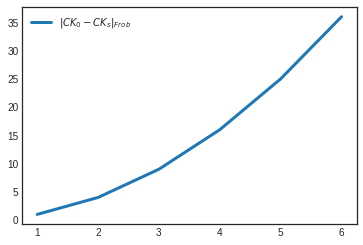

In [ ]:
a = [1,2,3,4,5,6]
b = [1,4,9,16,25,36]
fig,ax = plt.subplots(1,1)
ax.plot(a,b,linewidth=3,label='$\|CK_0-CK_s\|_{Frob}$')
ax.legend()